In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sbi.inference import NPE, simulate_for_sbi
from sbi.neural_nets import posterior_nn
import torch
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sbi import utils as sbi_utils
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

/home/sam/miniconda3/envs/pandora/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# Configuration
num_samples = 100
t_max = 20
num_timesteps = 64
num_masses = 1
x_data = np.abs(np.cumsum(np.random.rand(num_samples, num_timesteps, 1) - 0.5, axis=1))
t_data = np.linspace(0, t_max, num_timesteps)
num_simulations=400000

In [23]:
# [WALL]--(k0,b0)--[m0]--(k1,b1)--[m1]--(k2,b2)--[m2]

# Define system of equations
def multi_mass_spring_damper(y, t, m, k, b, F_ext=None):
    """
    y: concatenated [x0, x1, ..., xn, v0, v1, ..., vn]
    m, k, b: arrays of length n
    F_ext: optional external force per mass at time t
    """
    n = len(m)
    x = y[:n]
    v = y[n:]
    
    dxdt = v
    dvdt = np.zeros(n)

    for i in range(n):
        # External force
        F = 0
        if F_ext is not None:
            F = np.interp(t, t_data, F_ext[i])
        else:
            F = 2

        # Spring-damper forces from neighbors
        force = 0

        # Left spring/damper: wall or previous mass
        if i == 0: 
         force += -k[0] * x[0] - b[0] * v[0]  # connected to wall
        else:
            force += -k[i] * (x[i] - x[i-1]) - b[i] * (v[i] - v[i-1])

        # Right spring/damper: next mass if not last
        if i < n - 1:
            force += -k[i+1] * (x[i] - x[i+1]) - b[i+1] * (v[i] - v[i+1])

        dvdt[i] = (F + force) / m[i]

    return np.concatenate([dxdt, dvdt])


def multi_msd_simulator(params, F_ext=None):
    """
    params: [m0, m1, ..., k0, k1, ..., b0, b1, ...]
    """
    m = np.array(params[:num_masses])
    k = np.array(params[num_masses:2*num_masses])
    b = np.array(params[2*num_masses:3*num_masses])

    t = np.linspace(0, 10, num_timesteps)
    y0 = np.zeros(2 * num_masses)  # Initial positions and velocities

    sol = odeint(multi_mass_spring_damper, y0, t, args=(m, k, b, F_ext))

    x = sol[:, :num_masses]
    v = sol[:, num_masses:]

    return extract_summary_statistics_multimass(t, x, v)

def multi_msd_simulator_raw(params, F_ext=None):

    m = np.array(params[:num_masses])
    k = np.array(params[num_masses:2*num_masses])
    b = np.array(params[2*num_masses:3*num_masses])

    t = np.linspace(0, 10, num_timesteps)
    y0 = np.zeros(2 * num_masses)  # Initial positions and velocities

    sol = odeint(multi_mass_spring_damper, y0, t, args=(m, k, b, F_ext))

    x = sol[:, :num_masses]
    v = sol[:, num_masses:]

    return t, x, v


def extract_summary_statistics_multimass(t, x, v):
    num_masses = x.shape[1]

    # Compute stats per mass
    stats = []
    for i in range(num_masses):
        stats.extend(extract_summary_statistics(t, x[:, i], v[:, i]))

    return np.array(stats)


def extract_summary_statistics(t, x, v):
    steady_state = x[-1]

    # Settling time
    settling_idx = np.where(np.abs(x - steady_state) <= 0.05 * np.abs(steady_state))[0]
    settling_time = t[settling_idx[0]] if len(settling_idx) > 0 else np.nan

    # Rise time (time to go from 10% to 90% of final value)
    try:
        rise_start = np.where(x >= 0.1 * steady_state)[0][0]
        rise_end = np.where(x >= 0.9 * steady_state)[0][0]
        rise_time = t[rise_end] - t[rise_start]
    except IndexError:
        rise_time = np.nan

    # Peak overshoot
    peak_overshoot = (np.max(x) - steady_state) / steady_state if steady_state != 0 else np.nan

    # Final position and velocity
    final_position = x[-1]
    final_velocity = v[-1]

    # Mean and variance of position and velocity (to handle randomness)
    mean_position = np.mean(x)
    var_position = np.var(x)
    mean_velocity = np.mean(v)
    var_velocity = np.var(v)
    energy = np.sum(x**2)
    max_rate_of_change = np.max(np.diff(x) / np.diff(t))

    # Combine all summary stats into a single vector
    summary_stats = np.array([
        settling_time, rise_time, peak_overshoot,
        final_position, final_velocity,
        mean_position, var_position,
        mean_velocity, var_velocity,
        energy, max_rate_of_change
    ])
    
    # Handle any NaNs with a fallback value (e.g., -1 or zero)
    summary_stats = np.nan_to_num(summary_stats, nan=-1)

    return summary_stats

def generate_deterministic_force(timesteps, num_masses, seed=42, smoothing=2.0):
    rng = np.random.default_rng(seed)
    raw = rng.random(timesteps) - 0.5
    force = np.cumsum(raw)
    force = gaussian_filter1d(force, sigma=smoothing)
    force = np.abs(force)
    return np.tile(force, (num_masses, 1)) 

def generate_stochastic_force(timesteps, num_masses, seed=None, smoothing=1.5):
    rng = np.random.default_rng(seed)
    # Random walk force signal
    F_shared = np.abs(np.cumsum(rng.random(timesteps) - 0.5))
    # Optional smoothing
    if smoothing is not None and smoothing > 0:
        F_shared = gaussian_filter1d(F_shared, sigma=smoothing)
    # Tile for each mass
    return np.tile(F_shared, (num_masses, 1))

def simulator(params):

    F_ext = generate_stochastic_force(num_timesteps, num_masses)

    # F_ext = generate_deterministic_force(num_timesteps, num_masses)

    # F_ext = np.abs(np.cumsum(np.random.rand(num_masses, num_timesteps) - 0.5, axis=1))

    return multi_msd_simulator(params, F_ext=F_ext)

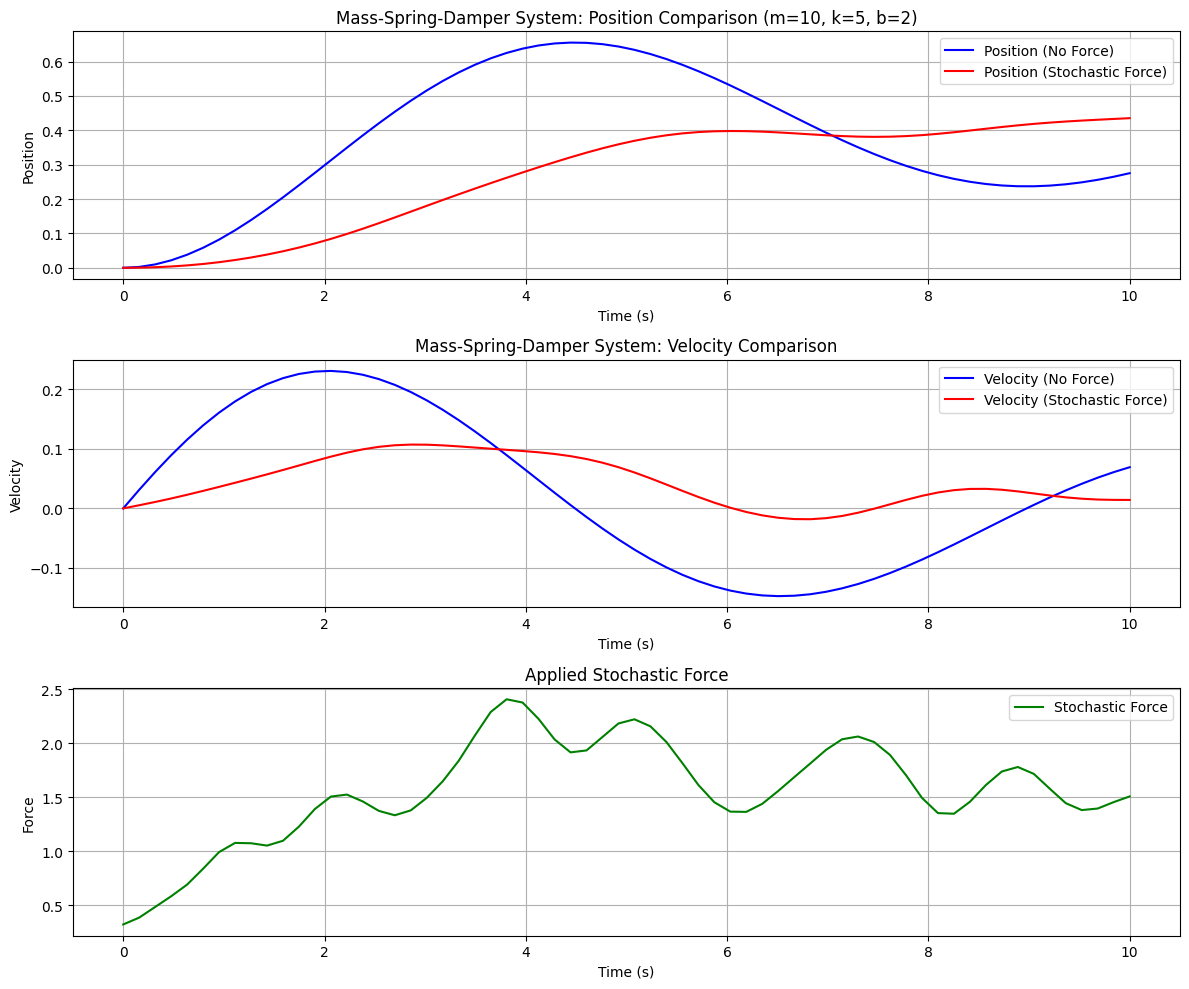

In [24]:
# Let's compare the mass-spring-damper system behavior with and without stochastic force
# Setting parameters: m=10, k=5, b=2

# Define time points
t = np.linspace(0, 10, num_timesteps)

# First, simulate system with no external force
params_fixed = np.array([10., 5., 2.])  # [m, k, b]
t_no_force, x_no_force, v_no_force = multi_msd_simulator_raw(params_fixed, F_ext=None)

# Second, simulate with stochastic force
# Use a fixed seed for reproducibility
force_stochastic = generate_stochastic_force(num_timesteps, num_masses, seed=42)
t_stoch, x_stoch, v_stoch = multi_msd_simulator_raw(params_fixed, F_ext=force_stochastic)

# Create comparison plots
plt.figure(figsize=(12, 10))

# Plot position comparison
plt.subplot(3, 1, 1)
plt.plot(t_no_force, x_no_force, 'b-', label='Position (No Force)')
plt.plot(t_stoch, x_stoch, 'r-', label='Position (Stochastic Force)')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.title('Mass-Spring-Damper System: Position Comparison (m=10, k=5, b=2)')
plt.legend()
plt.grid(True)

# Plot velocity comparison
plt.subplot(3, 1, 2)
plt.plot(t_no_force, v_no_force, 'b-', label='Velocity (No Force)')
plt.plot(t_stoch, v_stoch, 'r-', label='Velocity (Stochastic Force)')
plt.xlabel('Time (s)')
plt.ylabel('Velocity')
plt.title('Mass-Spring-Damper System: Velocity Comparison')
plt.legend()
plt.grid(True)

# Plot the stochastic force
plt.subplot(3, 1, 3)
plt.plot(t_stoch, force_stochastic.T, 'g-', label='Stochastic Force')
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.title('Applied Stochastic Force')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [5]:
# Prior distribution for (m, k, b) — assuming you know rough ranges
num_params = 3 * num_masses 

prior = sbi_utils.BoxUniform(
    low=torch.tensor([0.1] * num_params),
    high=torch.tensor([10.0] * num_params)
)

prior, num_parameters, prior_returns_numpy = process_prior(prior)

simulator_wrapper0 = process_simulator(
    simulator,
    prior,
    prior_returns_numpy
)

check_sbi_inputs(simulator_wrapper0, prior)

# Create inference object
inference0 = NPE(prior)

In [6]:
theta0, x0 = simulate_for_sbi(simulator_wrapper0, prior, num_simulations=num_simulations)

  0%|          | 0/400000 [00:00<?, ?it/s]

In [7]:
# Train the inference network
density_estimator0 = inference0.append_simulations(theta0, x0).train()

# Build posterior
posterior0 = inference0.build_posterior(density_estimator0)

 Neural network successfully converged after 188 epochs.

In [8]:
def get_param_labels_and_values(sample, num_masses):
    """
    Given a sample tensor and number of masses, returns a list of parameter values and their labels.
    Assumes sample shape is (1, 3*num_masses) or (3*num_masses,).
    """
    sample = sample.flatten()
    m = sample[:num_masses].tolist()
    k = sample[num_masses:2*num_masses].tolist()
    b = sample[2*num_masses:3*num_masses].tolist()
    params = m + k + b
    labels = [f"m{i}" for i in range(num_masses)] + \
             [f"k{i}" for i in range(num_masses)] + \
             [f"b{i}" for i in range(num_masses)]
    return params, labels

In [9]:
sample = prior.sample((1,))
force_func = lambda: generate_stochastic_force(num_timesteps, num_masses, 42)

In [10]:
observed_data0 = simulator(sample.numpy()[0])
observed_data0 = torch.tensor(observed_data0, dtype=torch.float32)
# Infer parameters
samples0 = posterior0.sample((100000,), x=observed_data0)
# Get posterior mean (or median)
mean_sample0 = samples0.mean(dim=0)  # shape: (3 * num_masses,)
params, labels = get_param_labels_and_values(mean_sample0, num_masses)
for i, label in enumerate(labels):
    print(f"T {label}: {sample[0][i]:.4f}, I {label}: {params[i]:.4f}")

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

T m0: 5.4302, I m0: 5.0055
T m1: 8.1733, I m1: 8.2588
T k0: 3.2004, I k0: 2.7691
T k1: 5.5784, I k1: 4.9777
T b0: 2.5172, I b0: 3.5730
T b1: 5.2388, I b1: 6.1832


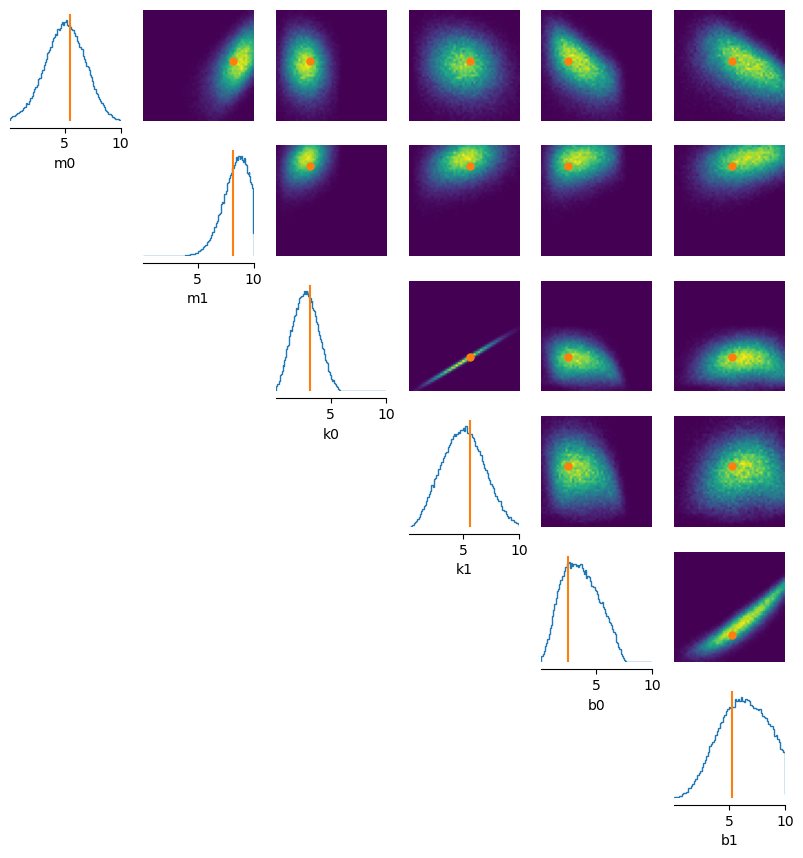

In [11]:
from sbi import analysis

fig, ax = analysis.pairplot(
    samples0,
    points=sample,
    labels=labels,
    limits=[[float(l), float(h)] for l, h in zip(prior.base_dist.low.numpy(), prior.base_dist.high.numpy())]
)

In [12]:
def plot_posterior_prediction_band(
    posterior,
    x_o,
    simulator_raw,
    force_func,
    mass_index=0,
    num_samples=100,
    show_samples=False,
    plot_position=True,
    plot_velocity=True,
    color='C0',
    label='Posterior Predictive'
):
    import matplotlib.pyplot as plt
    import numpy as np

    x_trajectories = []
    v_trajectories = []
    t_ref = None

    theta_samples = posterior.sample((num_samples,), x=x_o).numpy().squeeze()
    for theta_sample in theta_samples:
        t, x, v = simulator_raw(theta_sample, force_func())
        if t_ref is None:
            t_ref = t
        x_trajectories.append(x[:, mass_index])
        v_trajectories.append(v[:, mass_index])

    x_trajectories = np.stack(x_trajectories)
    v_trajectories = np.stack(v_trajectories)

    def plot_quantile_bands(data, t, base_color, variable_name):
        # CI levels from narrow (dense) to wide
        quantiles = [50, 70, 90]
        alphas = [0.25, 0.18, 0.12]
        for q, alpha in zip(quantiles, alphas):
            lower = np.percentile(data, 50 - q / 2, axis=0)
            upper = np.percentile(data, 50 + q / 2, axis=0)
            plt.fill_between(t, lower, upper, color=base_color, alpha=alpha,
                             label=f'{label} ${variable_name}_{mass_index}$ ({q}% CI)' if q == 90 else None)

        median = np.median(data, axis=0)
        plt.plot(t, median, color=base_color, lw=2, label=f'{label} ${variable_name}_{mass_index}$ (Median)')

    if plot_position:
        plot_quantile_bands(x_trajectories, t_ref, base_color=color, variable_name='x')
        if show_samples:
            for traj in x_trajectories:
                plt.plot(t_ref, traj, color=color, alpha=0.05, lw=0.6)

    if plot_velocity:
        plot_quantile_bands(v_trajectories, t_ref, base_color='C1', variable_name='v')
        if show_samples:
            for traj in v_trajectories:
                plt.plot(t_ref, traj, color='C1', alpha=0.05, lw=0.6)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

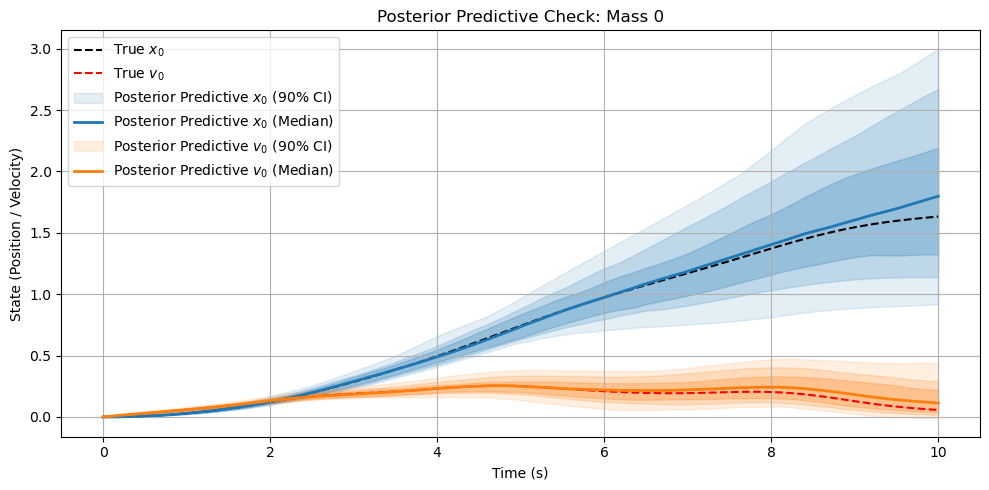

In [13]:
# force_func = generate_stochastic_force(num_timesteps, num_masses, 42)
# Ground truth trajectory
true_params = sample.flatten()
t_real, x_real, v_real = multi_msd_simulator_raw(true_params, force_func())
x_o = extract_summary_statistics_multimass(t_real, x_real, v_real)

# Plot
plt.figure(figsize=(10, 5))

# True trajectories
plt.plot(t_real, x_real[:, 0], '--k', label='True $x_0$')
plt.plot(t_real, v_real[:, 0], '--r', label='True $v_0$')

# Posterior predictions
plot_posterior_prediction_band(
    posterior0,
    x_o,
    simulator_raw=multi_msd_simulator_raw,
    force_func=force_func,
    mass_index=0,
    num_samples=100,
    plot_position=True,
    plot_velocity=True,
    show_samples=False
)

plt.xlabel("Time (s)")
plt.ylabel("State (Position / Velocity)")
plt.title("Posterior Predictive Check: Mass 0")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
def stack_xv(x, v):
    """
    Stack position and velocity arrays into channel-first format.
    Input:
        x, v: arrays of shape [timesteps, num_masses]
    Returns:
        stacked: [2 * num_masses, timesteps]
    """
    x = np.asarray(x).T  # [num_masses, timesteps]
    v = np.asarray(v).T
    return np.vstack([x, v])  # [2*num_masses, timesteps]

class HybridEmbedding(nn.Module):
    def __init__(self, seq_embed_net, seq_len, stats_dim=10, num_masses=1, fused_dim=10):
        super().__init__()
        self.seq_embed_net = seq_embed_net
        self.stats_dim = stats_dim
        self.seq_shape = (2 * num_masses, seq_len)

        self.stats_fc = nn.Sequential(
            nn.Linear(stats_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.fusion = nn.Sequential(
            nn.Linear(16 + fused_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

    def forward(self, x):  # x shape: [batch, (2*num_masses)*seq_len + stats_dim]
        seq_flat = x[:, :-self.stats_dim]
        stats = x[:, -self.stats_dim:]

        # Reshape to [B, 2*num_masses, T]
        seq = seq_flat.view(x.shape[0], *self.seq_shape)

        seq_embed = self.seq_embed_net(seq)
        stats_embed = self.stats_fc(stats)

        combined = torch.cat([seq_embed, stats_embed], dim=1)
        return self.fusion(combined)

class LSTMEmbedding(nn.Module):
    def __init__(self, num_masses, hidden_size=64, output_size=10, num_layers=1):
        super().__init__()
        self.input_size = 2 * num_masses  # x and v per mass

        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        self.output_net = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        # x shape: [batch_size, channels=2*num_masses, time]
        x = x.permute(0, 2, 1)  # [batch_size, time, channels]
        _, (hn, _) = self.lstm(x)  # [num_layers, batch, hidden]
        embedding = hn[-1]  # last layer’s hidden state
        return self.output_net(embedding)
    

def msd_hybrid(theta, simulator_raw, summary_fn, force_fn):
    """
    Creates a hybrid input vector by combining trajectory sequence and summary statistics.

    Parameters:
        theta: Parameter vector (e.g., shape [12])
        simulator_raw: Function that returns (t, x, v)
        summary_fn: Callable that takes (t, x, v) and returns summary stats
        force_fn: Callable that generates external force

    Returns:
        hybrid_vector: Flattened [2 * num_masses * timesteps + stats_dim] vector (float32)
    """
    t, x, v = simulator_raw(theta, F_ext=force_fn())
    seq = stack_xv(x, v)  # Shape: [2 * num_masses, timesteps]
    stats = summary_fn(t, x, v)  # e.g., shape [10]

    # Flatten and concatenate
    hybrid_vector = np.concatenate([seq.flatten(), stats], axis=0)
    return hybrid_vector.astype(np.float32)

In [15]:
sequence_net = LSTMEmbedding(num_masses)
embedding_net = HybridEmbedding(seq_embed_net=sequence_net, stats_dim=11*num_masses, num_masses=num_masses, seq_len=num_timesteps)

density_estimator = posterior_nn(model='maf', embedding_net=embedding_net)
inference = NPE(prior=prior, density_estimator=density_estimator)

simulator_wrapper = process_simulator(
    lambda theta: msd_hybrid(
        theta,
        simulator_raw=multi_msd_simulator_raw,
        summary_fn=extract_summary_statistics_multimass,
        force_fn=lambda: generate_stochastic_force(num_timesteps, num_masses) # must use seed of zero here
    ),
    prior,
    prior_returns_numpy
)
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=num_simulations)

  0%|          | 0/400000 [00:00<?, ?it/s]

In [16]:
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

 Neural network successfully converged after 232 epochs.

In [17]:
# sample = prior.sample((1,))
# use same sample as before for more clear comparison
force_func2 = generate_stochastic_force(num_timesteps, num_masses, 42)
observed_data = msd_hybrid(
        sample.numpy()[0],
        simulator_raw=multi_msd_simulator_raw,
        summary_fn=extract_summary_statistics_multimass,
        force_fn=force_func
    )
observed_data = torch.tensor(observed_data, dtype=torch.float32)
# Infer parameters
samples = posterior.sample((100000,), x=observed_data)
# Get posterior mean (or median)
mean_sample = samples.mean(dim=0)  # shape: (3 * num_masses,)
params, labels = get_param_labels_and_values(mean_sample, num_masses)
for i, label in enumerate(labels):
    print(f"T {label}: {sample[0][i]:.4f}, I {label}: {params[i]:.4f}")

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

T m0: 5.4302, I m0: 5.4187
T m1: 8.1733, I m1: 8.1274
T k0: 3.2004, I k0: 3.2825
T k1: 5.5784, I k1: 5.7002
T b0: 2.5172, I b0: 2.4057
T b1: 5.2388, I b1: 5.2128


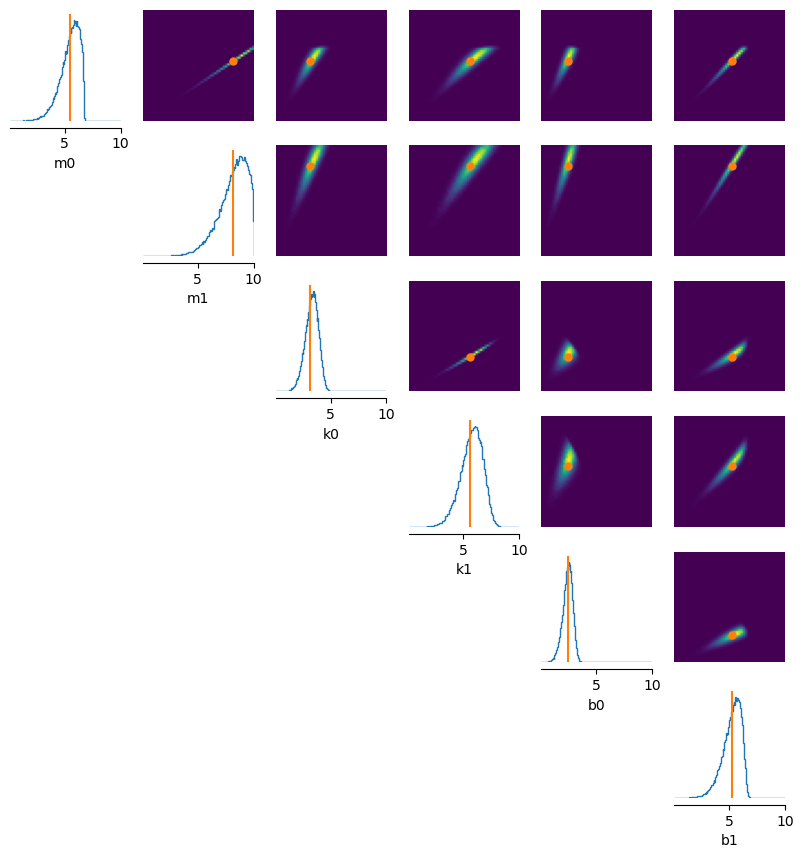

In [18]:
fig, ax = analysis.pairplot(
    samples,
    points=sample,
    labels=labels,
    limits=[[float(l), float(h)] for l, h in zip(prior.base_dist.low.numpy(), prior.base_dist.high.numpy())]
)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

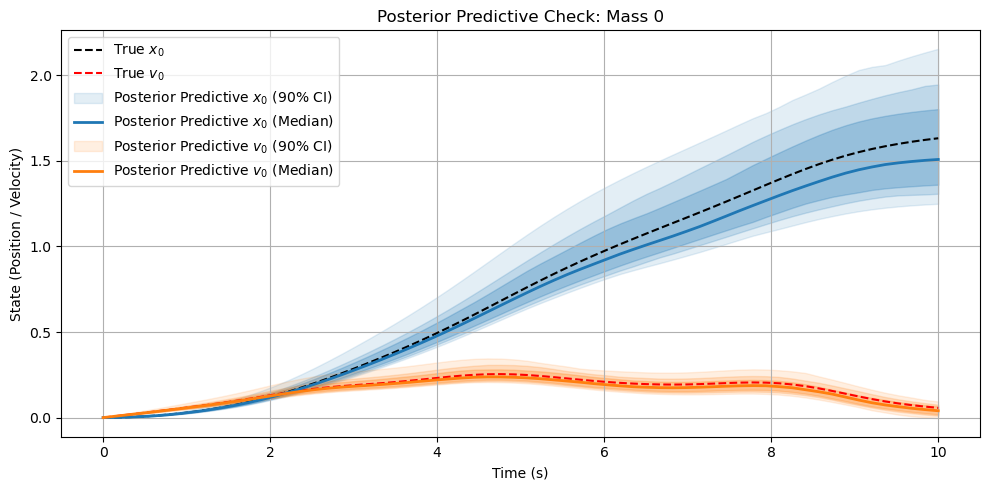

In [19]:
# Ground truth trajectory
true_params = sample.flatten()
t_real, x_real, v_real = multi_msd_simulator_raw(true_params, force_func())
x_o = msd_hybrid(        
        true_params,
        simulator_raw=multi_msd_simulator_raw,
        summary_fn=extract_summary_statistics_multimass,
        force_fn=force_func
    )

# Plot
plt.figure(figsize=(10, 5))

# True trajectories
plt.plot(t_real, x_real[:, 0], '--k', label='True $x_0$')
plt.plot(t_real, v_real[:, 0], '--r', label='True $v_0$')

# Posterior predictions
plot_posterior_prediction_band(
    posterior,
    x_o,
    simulator_raw=multi_msd_simulator_raw,
    force_func=force_func,
    mass_index=0,
    num_samples=100,
    plot_position=True,
    plot_velocity=True,
    show_samples=False
)

plt.xlabel("Time (s)")
plt.ylabel("State (Position / Velocity)")
plt.title("Posterior Predictive Check: Mass 0")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
import pickle
with open(f"./models/msd_hybrid_{num_simulations}.pkl", "wb") as handle:
    pickle.dump(posterior, handle)

In [21]:
# with open(f"./models/msd_hybrid_{num_simulations}.pkl", "rb") as handle:
#     posterior = pickle.load(handle)

In [22]:
# T m0: 1.4746, I m0: 1.4631
# T k0: 9.4530, I k0: 9.4857
# T b0: 5.9971, I b0: 5.9304